In [4]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.layers import Dense



Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
#Extract data from CSV
df1=pd.read_csv("csvs/usgs_main_no_far.csv", encoding='utf-8', quotechar='"', delimiter=',')

In [10]:
epoch = datetime(1970, 1, 1)

def mapdateTotime(x):
    try:
        dt = datetime.strptime(x, "%m/%d/%Y")
    except ValueError:
        dt = datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ")
    diff = dt - epoch
    return diff.total_seconds()

df1.time = df1.time.apply(mapdateTotime)

In [41]:
col1 = df1[['time','latitude','longitude', 'plate_boundary_distance']]
col2 = df1[['mag']]

#Convert to Numpy array
col1_clean = col1.dropna()
col2_clean = col2.dropna()


InputX1 = col1_clean.to_numpy()
InputY1 = col2_clean.to_numpy()


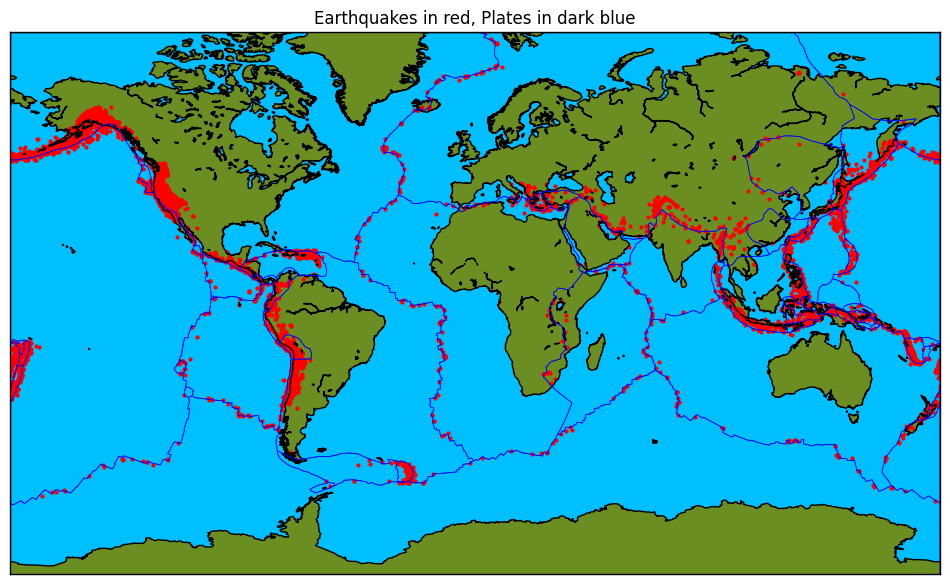

In [42]:
# Visualization

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='l')
longitudes = df1["longitude"].tolist()
latitudes = df1["latitude"].tolist()
x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("Earthquakes in red, Plates in dark blue")
m.plot(x, y, "o", markersize = 2, color = 'red')


m.drawcoastlines()
m.fillcontinents(color='olivedrab',lake_color='deepskyblue')
m.drawmapboundary(fill_color='deepskyblue')
m.readshapefile('tectonicplates-master/PB2002_plates', 
                name='tectonic_plates', 
                drawbounds=True, 
                color='blue')



plt.show()

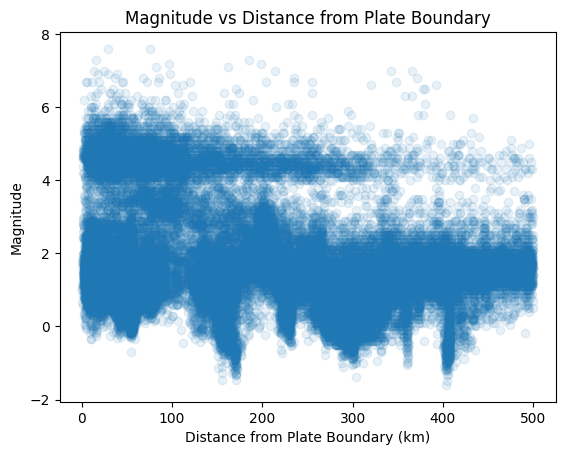

In [43]:
# Plot magnitude vs distance from plate boundary
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(df1['plate_boundary_distance'], df1['mag'], alpha=0.1)
ax.set_xlabel('Distance from Plate Boundary (km)')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs Distance from Plate Boundary')
plt.show()

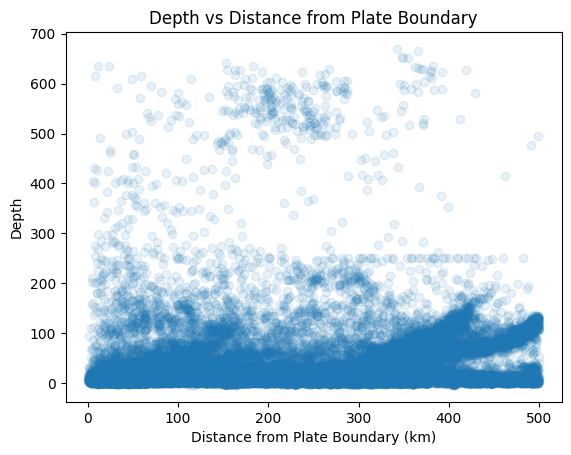

In [44]:
# Plot depth vs distance from plate boundary
fig, ax = plt.subplots()
ax.scatter(df1['plate_boundary_distance'], df1['depth'], alpha=0.1)
ax.set_xlabel('Distance from Plate Boundary (km)')
ax.set_ylabel('Depth')
ax.set_title('Depth vs Distance from Plate Boundary')
plt.show()

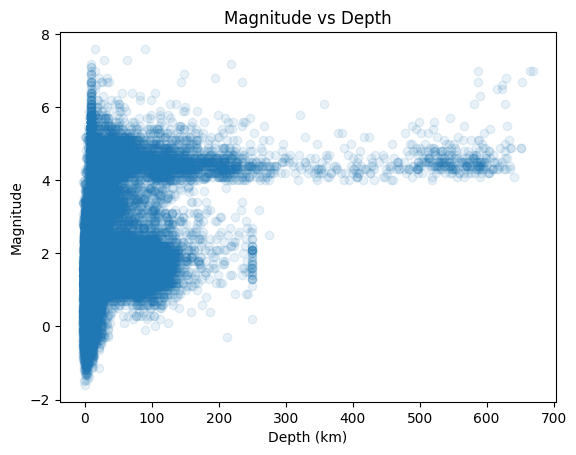

In [45]:
# Plot magnitude vs depth
fig, ax = plt.subplots()
ax.scatter(df1['depth'], df1['mag'], alpha=0.1)
ax.set_xlabel('Depth (km)')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs Depth')
plt.show()

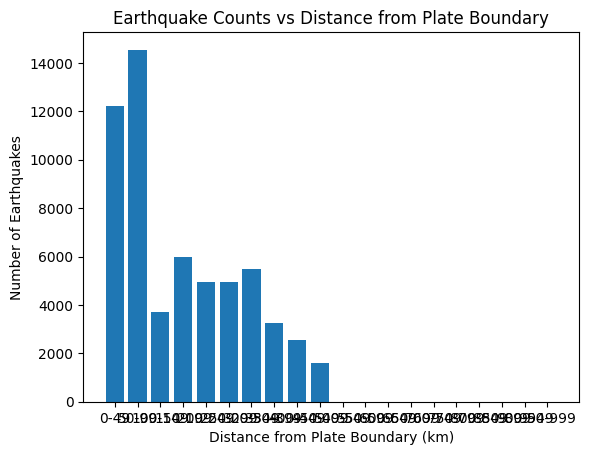

In [77]:
df2=pd.read_csv("csvs/usgs_main_no_far.csv", encoding='utf-8', quotechar='"', delimiter=',')
# Bin the distances into intervals of 50 km
bins = range(0, 1001, 50)
labels = [f"{i}-{i+49}" for i in range(0, 1000, 50)]
df2['distance_bin'] = pd.cut(df2['plate_boundary_distance'], bins=bins, labels=labels)

# Count the number of earthquakes in each distance bin
counts = df2['distance_bin'].value_counts().sort_index()

# Plot a bar chart of the earthquake counts
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_xlabel('Distance from Plate Boundary (km)')
ax.set_ylabel('Number of Earthquakes')
ax.set_title('Earthquake Counts vs Distance from Plate Boundary')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.show()

In [53]:
# Min-max Normalization
X1_min = np.amin(InputX1,0)     
X1_max = np.amax(InputX1,0)   
print("Mininum values:",X1_min)
print("Maximum values:",X1_max)
Y1_min = min(InputY1)     
Y1_max = max(InputY1)

InputX1_norm = (InputX1-X1_min)/(X1_max-X1_min)
InputY1_norm = InputY1  #No normalization in output


# Reshape
Xfeatures = 4 #Number of input features
Yfeatures = 1 #Number of input features
samples = 59000 # Number of samples

InputX1_reshape = np.resize(InputX1_norm,(samples,Xfeatures))
InputY1_reshape = np.resize(InputY1_norm,(samples,Yfeatures))



Mininum values: [ 1.64634343e+09 -6.51963000e+01 -1.79999700e+02  4.52584005e-01]
Maximum values: [1.67088457e+09 8.66293000e+01 1.80000000e+02 4.99996058e+02]


In [54]:
#Training data
train_size = 47000
InputX1train = InputX1[0:train_size,:]
InputY1train = InputY1[0:train_size, :]

#Validation data
v_size = 12000
InputX1v = InputX1[train_size:train_size+v_size,:]
InputY1v = InputY1[train_size:train_size+v_size, :]

In [55]:
learning_rate = 0.0005
training_iterations = 1000
display_iterations = 100

Here is a pretty poor random forest regression model for the problem. We see the reg.score is a value negative and close to zero, suggesting it is performing arbitrarily worse, and it's $R^2$ values are close to 0 suggesting it is picking a similar answer regardless of the input. 

In [60]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=42)
reg.fit(InputX1train, InputY1train)
reg.predict(InputX1v)

C:\Users\james\AppData\Local\Temp\ipykernel_31336\4275459395.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(InputX1train, InputY1train)


array([1.5399, 2.112 , 1.7895, ..., 3.0364, 1.9863, 2.1112])

In [62]:
reg.score(InputX1v, InputY1v)

-0.16145134795256566

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(InputX1[0:47000, :], InputY1[0:47000, :],test_size=0.2)

In [66]:
''' Linear Regression '''
li_reg = LinearRegression()
li_reg.fit(X_train, y_train)
li_reg.predict(X_test)

array([[1.59880175],
       [1.51856582],
       [1.53545697],
       ...,
       [1.48132279],
       [1.48802434],
       [1.58911754]])

In [67]:
li_reg.score(X_test, y_test)

0.00037695138526516736

In [68]:
''' RandomForestRegressor '''
rf_reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)
reg.predict(X_test)

C:\Users\james\AppData\Local\Temp\ipykernel_31336\958457549.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


array([0.9874, 0.924 , 3.1288, ..., 1.4178, 1.6718, 2.9443])

In [69]:
reg.score(X_test, y_test)

-0.06655133295006643

In [70]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(4,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

C:\Users\james\AppData\Local\Temp\ipykernel_31336\3126003353.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [130]:


neurons = [16, 64]
# neurons = [16]
batch_size = [10, 50, 100]
# batch_size = [10]
epochs = [10]
activation = ['relu', 'sigmoid', 'hard_sigmoid', 'exponential']
# activation = ['sigmoid', 'relu']
optimizer = ['SGD', 'Adam']
# optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\james\AppData\Local\Temp\ipykernel_21820\1693078399.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.699133 using {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.537200 (0.195688) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.544400 (0.194181) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adam'}
0.460000 (0.195135) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 64, 'optimizer': 'SGD'}
0.459667 (0.195067) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 64, 'optimizer': 'Adam'}
0.462667 (0.195663) with: {'activation': 'relu', 'batch_size': 50, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.621933 (0.157512) with: {'activation': 'relu', 'batch_size': 50, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adam'}
0.541400 (0.

In [71]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.1)
model.compile(loss = "squared_hinge", optimizer = 'adam')

model = Sequential()
model.add(Dense(40, activation='sigmoid', input_shape=(4,)))
model.add(Dense(20, activation='dropout'))
model.add(Dense(10))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer=opt, loss='squared_hinge', metrics=['accuracy'])

AttributeError: 'KerasClassifier' object has no attribute 'compile'

In [72]:
model.fit(X_train, y_train, batch_size=256, epochs=250, verbose=1, validation_data=(X_test, y_test))

TypeError: create_model() missing 4 required positional arguments: 'neurons', 'activation', 'optimizer', and 'loss'

In [99]:
[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Evaluation result on Test Data : Loss = 0.674204041671753, accuracy = 0.8744000196456909


In [15]:
import json
from math import radians, sin, cos, sqrt, atan2
# Load the plate boundary data from the JSON file
with open("C:/EPSCI10/Seismograph-Earthquake-Detection/tectonicplates-master/GeoJSON/PB2002_boundaries.json") as f:
    data = json.load(f)

# Extract the latitude and longitude coordinates for each boundary point
boundaries = []
for feature in data["features"]:
    for lineString in feature["geometry"]["coordinates"]:
        lon, lat = lineString
        boundaries.append((lat, lon))

def calculate_plate_boundary_dist(long, lat):
    min_distance = float("inf")
    for boundary in boundaries:
        lat1, lon1 = radians(float(lat)), radians(float(long))
        lat2, lon2 = radians(boundary[0]), radians(boundary[1])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = 6371 * c  # Approximate radius of Earth in km
        if distance < min_distance:
            min_distance = distance
    return min_distance

In [20]:
import requests
import urllib.parse

#Testing

address = input("Enter a location (address or informal is fine):")

url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
response = requests.get(url).json()
lat = response[0]["lat"]
long = response[0]["lon"]

plate_boundary_distance = calculate_plate_boundary_dist(long, lat)

date = input("Enter the date (mm/dd/yyyy):")
InputX2 = np.asarray([[mapdateTotime(date),lat,long,plate_boundary_distance]],dtype=np.float32)

InputX2_norm = (InputX2-X1_min)/(X1_max-X1_min)
InputX1test = np.resize(InputX2_norm,(1,Xfeatures))
with tf.Session() as sess:
    # Restore variables from disk for validation.
    saver.restore(sess, "/tmp/earthquake_model.ckpt")

    #print("Final validation loss:",sess.run([mean_square],feed_dict={X:InputX1v,Y:InputY1v}))
    print("output:",sess.run([output_layer],feed_dict={X:InputX1test}))

    predicted_output = sess.run(output_layer, feed_dict={X: InputX1v})



INFO:tensorflow:Restoring parameters from /tmp/earthquake_model.ckpt
output: [array([[0.6889367]], dtype=float32)]
